In [1]:
# Import necessary libraries
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import f1_score, roc_curve, auc, jaccard_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm


In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define the dataset paths
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

class WoodDataset(Dataset):
    def __init__(self, image_paths, transform=None, grayscale=True):
        self.image_paths = image_paths
        self.transform = transform
        self.grayscale = grayscale

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        if self.grayscale:
            img = Image.open(img_path).convert('L')
            # Convert to 3-channel for pretrained models
            if self.transform:
                img = self.transform(img)
                img = torch.cat([img, img, img], dim=0)
        else:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)

        return img, img_path

# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Helper function to load image paths
def get_image_paths(folder_path):
    return sorted(glob(os.path.join(folder_path, '*.jpg')))

# Get image paths
train_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'train/good'))
test_good_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/good'))
test_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'test/defect'))
mask_defect_paths = get_image_paths(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Create datasets
train_dataset = WoodDataset(train_good_paths, transform=transform, grayscale=True)
test_good_dataset = WoodDataset(test_good_paths, transform=transform, grayscale=True)
test_defect_dataset = WoodDataset(test_defect_paths, transform=transform, grayscale=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_good_loader = DataLoader(test_good_dataset, batch_size=32, shuffle=False)
test_defect_loader = DataLoader(test_defect_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Test good samples: {len(test_good_dataset)}")
print(f"Test defect samples: {len(test_defect_dataset)}")

Train samples: 70
Test good samples: 70
Test defect samples: 71


In [5]:
class FeatureExtractor(torch.nn.Module):
    """
    Feature extractor for the PADIM model using pretrained CNN.
    Extracts features from multiple layers to capture multi-scale information.
    """
    def __init__(self, backbone='resnet18'):
        super(FeatureExtractor, self).__init__()

        # Load the pretrained model
        if backbone == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            # Modify first conv for grayscale input (1 channel to 3)
            self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            # Feature dimensions from different layers
            self.layers = {
                'layer1': (64, 64, 64),   # Feature size for 256x256 input
                'layer2': (128, 32, 32),
                'layer3': (256, 16, 16)
            }

            # Identify feature extraction layers
            self.feature_layers = ['layer1', 'layer2', 'layer3']

        elif backbone == 'wide_resnet50_2':
            self.model = models.wide_resnet50_2(pretrained=True)
            self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.layers = {
                'layer1': (256, 64, 64),
                'layer2': (512, 32, 32),
                'layer3': (1024, 16, 16)
            }
            self.feature_layers = ['layer1', 'layer2', 'layer3']

        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Set model to evaluation mode
        self.model.eval()

        # Calculate total feature dimension
        self.total_dim = sum([self.layers[layer][0] for layer in self.feature_layers])

    def forward(self, x):
        """
        Extract features from multiple layers

        Args:
            x: Input image batch

        Returns:
            Dictionary of features from each specified layer
        """
        features = {}

        # First conv and maxpool
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        # Extract features from different layers
        x = self.model.layer1(x)
        features['layer1'] = x

        x = self.model.layer2(x)
        features['layer2'] = x

        x = self.model.layer3(x)
        features['layer3'] = x

        return features

class PADIM:
    """
    PADIM (Patch Distribution Modeling) for anomaly detection
    """
    def __init__(self, backbone='resnet18', d_reduced=100):
        """
        Initialize PADIM model

        Args:
            backbone: CNN backbone for feature extraction
            d_reduced: Reduced feature dimension for memory efficiency
        """
        self.backbone = backbone
        self.d_reduced = d_reduced

        # Feature extractor
        self.feature_extractor = FeatureExtractor(backbone).to(device)

        # Dimension of features before reduction
        self.total_dim = self.feature_extractor.total_dim

        # Parameters for distribution modeling
        self.means = None
        self.cov_invs = None
        self.feature_shape = None  # Will store (C, H, W) of the embedding

        # Random projection matrix for dimension reduction
        self.random_projection = None
        self.embedding_ids = None

    def _set_random_projection(self):
        """
        Generate random projection matrix for dimension reduction
        """
        # Select a subset of features randomly for efficiency
        if self.d_reduced < self.total_dim:
            self.embedding_ids = torch.randperm(self.total_dim)[:self.d_reduced]
        else:
            self.embedding_ids = torch.arange(self.total_dim)
            self.d_reduced = self.total_dim

        print(f"Reduced feature dimension: {self.d_reduced}")

    def _extract_features(self, data_loader):
        """
        Extract and concatenate features from multiple layers

        Args:
            data_loader: DataLoader for the dataset

        Returns:
            feature_maps: Dictionary of feature maps
            patches_per_image: Number of spatial locations in the feature map
        """
        self.feature_extractor.eval()
        feature_maps = []
        filenames = []

        with torch.no_grad():
            for imgs, paths in tqdm(data_loader, desc="Extracting features"):
                imgs = imgs.to(device)
                # Get features from multiple layers
                features = self.feature_extractor(imgs)

                # For each location (h,w), concatenate the features from all layers
                layer_features = []
                for layer_name in self.feature_extractor.feature_layers:
                    layer_feat = features[layer_name]
                    # Resize to match the largest feature map (layer1)
                    if layer_name != 'layer1':
                        layer_size = self.feature_extractor.layers['layer1'][1]
                        layer_feat = torch.nn.functional.interpolate(
                            layer_feat, size=(layer_size, layer_size), mode='bilinear'
                        )
                    layer_features.append(layer_feat)

                # Concatenate features from all layers
                concat_features = torch.cat(layer_features, dim=1)
                feature_maps.append(concat_features.cpu())
                filenames.extend(paths)

                # Get the feature shape from first batch
                if self.feature_shape is None:
                    self.feature_shape = concat_features.shape[1:]  # (C, H, W)

        # Concatenate all extracted features
        feature_maps = torch.cat(feature_maps, dim=0)

        # Calculate number of spatial locations in each feature map
        h, w = self.feature_shape[1:]
        patches_per_image = h * w

        return feature_maps, filenames, patches_per_image

    def fit(self, train_loader):
        """
        Fit multivariate Gaussian distributions on normal patch features

        Args:
            train_loader: DataLoader with normal samples for training
        """
        # Extract features from normal training data
        feature_maps, _, patches_per_image = self._extract_features(train_loader)

        # Generate random projection matrix if needed
        if self.embedding_ids is None:
            self._set_random_projection()

        # For each spatial location, fit multivariate Gaussian
        n_samples = feature_maps.shape[0]  # Number of training samples
        C = self.feature_shape[0]  # Total feature channels
        H, W = self.feature_shape[1:]  # Height and width of feature maps

        print(f"Feature shape: {self.feature_shape}")
        print(f"Fitting multivariate Gaussian to {H*W} spatial locations...")

        # Apply dimension reduction
        # Reshape: [N, C, H, W] -> [N, H, W, C] -> [N*H*W, C]
        embeddings = feature_maps.permute(0, 2, 3, 1).reshape(n_samples * H * W, C)
        # Select subset of dimensions
        reduced_embeddings = embeddings[:, self.embedding_ids]
        # Reshape back: [N*H*W, d_reduced] -> [N, H, W, d_reduced]
        reduced_embeddings = reduced_embeddings.reshape(n_samples, H, W, self.d_reduced)

        # Calculate mean and covariance for each patch location
        means = torch.mean(reduced_embeddings, dim=0)  # Shape: [H, W, d_reduced]

        # Calculate covariance matrices
        # Iterate over spatial locations to save memory
        cov_invs = torch.zeros(H, W, self.d_reduced, self.d_reduced)

        for h in tqdm(range(H), desc="Computing covariance matrices"):
            for w in range(W):
                patch_features = reduced_embeddings[:, h, w, :]  # Shape: [N, d_reduced]
                # Add small epsilon to diagonal for numerical stability
                cov = torch.cov(patch_features.T) + 0.01 * torch.eye(self.d_reduced)
                # Calculate inverse covariance (precision matrix)
                try:
                    cov_inv = torch.inverse(cov)
                    cov_invs[h, w] = cov_inv
                except:
                    # Fallback to less numerically sensitive method
                    cov_inv = torch.pinverse(cov)
                    cov_invs[h, w] = cov_inv

        # Store the model parameters
        self.means = means
        self.cov_invs = cov_invs

        print("PADIM model fitting completed")
        return self

    def predict(self, test_loader):
        """
        Predict anomaly scores for test images using Mahalanobis distance

        Args:
            test_loader: DataLoader with test samples

        Returns:
            Dictionary with anomaly scores and score maps
        """
        # Extract features from test data
        feature_maps, filenames, patches_per_image = self._extract_features(test_loader)

        # Get dimensions
        n_samples = feature_maps.shape[0]
        C = self.feature_shape[0]
        H, W = self.feature_shape[1:]

        # Apply dimension reduction
        embeddings = feature_maps.permute(0, 2, 3, 1).reshape(n_samples * H * W, C)
        reduced_embeddings = embeddings[:, self.embedding_ids]
        reduced_embeddings = reduced_embeddings.reshape(n_samples, H, W, self.d_reduced)

        # Calculate Mahalanobis distance for each patch
        dist_maps = torch.zeros(n_samples, H, W)

        for h in tqdm(range(H), desc="Computing Mahalanobis distances"):
            for w in range(W):
                patch_features = reduced_embeddings[:, h, w, :]  # Shape: [N, d_reduced]

                # Calculate Mahalanobis distance
                delta = patch_features - self.means[h, w]  # Shape: [N, d_reduced]

                # Manual Mahalanobis calculation using inverse covariance
                m_dists = torch.zeros(n_samples)
                for i in range(n_samples):
                    m_dists[i] = torch.sqrt(
                        torch.mm(
                            torch.mm(delta[i].unsqueeze(0), self.cov_invs[h, w]),
                            delta[i].unsqueeze(1)
                        )
                    )

                dist_maps[:, h, w] = m_dists

        # Apply smoothing for better visualization
        score_maps = torch.zeros_like(dist_maps)
        for i in range(n_samples):
            score_maps[i] = torch.from_numpy(
                gaussian_filter(dist_maps[i].numpy(), sigma=4)
            )

        # Calculate image-level scores (max of patch scores)
        img_scores = torch.max(score_maps.reshape(n_samples, -1), dim=1)[0]

        # Convert to numpy for easier handling
        score_maps_np = score_maps.numpy()
        img_scores_np = img_scores.numpy()

        # Load the images for visualization
        test_imgs = []
        for batch, _ in test_loader:
            test_imgs.extend(batch.cpu())

        return {
            "scores": img_scores_np,
            "score_maps": score_maps_np,
            "images": test_imgs,
            "filenames": filenames
        }

In [6]:
# Initialize PADIM model
padim = PADIM(backbone='resnet18', d_reduced=100)

# Fit the model on normal samples
padim.fit(train_loader)

# Predict on test samples
print("Evaluating on normal test samples...")
test_good_results = padim.predict(test_good_loader)

print("Evaluating on defect test samples...")
test_defect_results = padim.predict(test_defect_loader)

# Combine results for evaluation
all_scores = np.concatenate([test_good_results["scores"], test_defect_results["scores"]])
all_maps = np.concatenate([test_good_results["score_maps"], test_defect_results["score_maps"]])
all_imgs = test_good_results["images"] + test_defect_results["images"]

# Ground truth labels (0 for normal, 1 for anomaly)
y_true = np.array([0] * len(test_good_results["scores"]) + [1] * len(test_defect_results["scores"]))

# Calculate ROC curve and optimal threshold
fpr, tpr, thresholds = roc_curve(y_true, all_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Generate predictions based on the optimal threshold
y_pred = (all_scores > optimal_threshold).astype(int)

# Calculate F1 score and ROC AUC
f1 = f1_score(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate scores statistics for good and defect samples
good_scores = test_good_results["scores"]
defect_scores = test_defect_results["scores"]

print(f"Good samples - Mean score: {np.mean(good_scores):.4f}, Max: {np.max(good_scores):.4f}, Min: {np.min(good_scores):.4f}")
print(f"Defect samples - Mean score: {np.mean(defect_scores):.4f}, Max: {np.max(defect_scores):.4f}, Min: {np.min(defect_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]
Extracting features: 100%|██████████| 3/3 [00:39<00:00, 13.23s/it]


Reduced feature dimension: 100
Feature shape: torch.Size([448, 64, 64])
Fitting multivariate Gaussian to 4096 spatial locations...


Computing covariance matrices: 100%|██████████| 64/64 [00:02<00:00, 27.16it/s]


PADIM model fitting completed
Evaluating on normal test samples...


Computing Mahalanobis distances: 100%|██████████| 64/64 [00:10<00:00,  6.00it/s]


Evaluating on defect test samples...


Computing Mahalanobis distances: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s]


Optimal threshold: 9.1665
F1 Score: 0.8919
ROC AUC: 0.9121
Good samples - Mean score: 6.8774, Max: 25.8729, Min: 2.9557
Defect samples - Mean score: 13.1977, Max: 27.6018, Min: 7.5503


In [7]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """Plot ROC curve with AUC."""
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_score_distributions(good_scores, defect_scores, threshold=None):
    """Plot distribution of anomaly scores for normal and anomalous samples."""
    plt.figure(figsize=(10, 6))
    plt.hist(good_scores, bins=30, alpha=0.5, label='Normal Samples', color='green')
    plt.hist(defect_scores, bins=30, alpha=0.5, label='Anomaly Samples', color='red')

    if threshold is not None:
        plt.axvline(x=threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.show()

def visualize_anomaly_detection(images, score_maps, scores, threshold, num_samples=5,
                                indices=None, cmap='viridis'):
    """
    Visualize anomaly detection results with original image, heatmap, and overlay.

    Args:
        images: List of test images
        score_maps: Array of anomaly score maps
        scores: Array of anomaly scores
        threshold: Threshold for anomaly detection
        num_samples: Number of samples to visualize
        indices: Optional specific indices to visualize
        cmap: Colormap for heatmap visualization
    """
    if indices is None:
        indices = np.random.choice(len(images), size=min(num_samples, len(images)), replace=False)

    plt.figure(figsize=(15, 3*len(indices)))

    for i, idx in enumerate(indices):
        # Get the image
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        # For grayscale (3 identical channels), take first channel
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]

        # Denormalize the image for better visualization
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map and normalize
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)

        # Resize score map to match image size
        score_map_resized = cv2.resize(score_map_norm, (img.shape[1], img.shape[0]))

        # Binary mask using threshold
        binary_mask = (score_map_resized > threshold).astype(float)

        is_anomaly = scores[idx] > threshold

        # Plot original image
        plt.subplot(len(indices), 3, 3*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{'Anomaly' if is_anomaly else 'Normal'} - Score: {scores[idx]:.4f}")
        plt.axis('off')

        # Plot heatmap
        plt.subplot(len(indices), 3, 3*i + 2)
        plt.imshow(score_map_resized, cmap=cmap)
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        # Plot overlay
        plt.subplot(len(indices), 3, 3*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(score_map_resized, cmap=cmap, alpha=0.5)
        plt.title('Anomaly Overlay')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

def visualize_segmentation_results(images, score_maps, scores, mask_paths, threshold, indices=None, num_samples=5):
    """
    Visualize segmentation results compared with ground truth masks.

    Args:
        images: List of test images
        score_maps: Array of anomaly score maps
        scores: Array of anomaly scores
        mask_paths: List of paths to ground truth masks
        threshold: Threshold for binary anomaly detection
        indices: Optional list of specific indices to visualize
        num_samples: Number of samples to visualize if indices is None
    """
    # Load ground truth masks
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)  # Binarize
        masks.append(mask)

    if indices is None:
        # Choose from defect samples only (assuming they're at the end of the list)
        start_idx = len(images) - len(masks)
        indices = np.random.choice(len(masks), size=min(num_samples, len(masks)), replace=False)
        indices = [start_idx + idx for idx in indices]  # Adjust indices to point to defect samples

    plt.figure(figsize=(16, 4*len(indices)))

    for i, idx in enumerate(indices):
        # Get image
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        if np.allclose(img[:,:,0], img[:,:,1]) and np.allclose(img[:,:,1], img[:,:,2]):
            img = img[:,:,0]
        img = (img - img.min()) / (img.max() - img.min())

        # Get score map
        score_map = score_maps[idx]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)
        score_map_resized = cv2.resize(score_map_norm, (img.shape[1], img.shape[0]))

        # Binary prediction mask
        pred_mask = (score_map_resized > threshold).astype(np.float32)

        # Get corresponding ground truth mask
        mask_idx = idx - (len(images) - len(masks))
        if 0 <= mask_idx < len(masks):
            gt_mask = masks[mask_idx]
        else:
            # Create empty mask if no ground truth available
            gt_mask = np.zeros_like(img)

        # Plot results
        plt.subplot(len(indices), 4, 4*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Anomaly - Score: {scores[idx]:.4f}")
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 2)
        plt.imshow(score_map_resized, cmap='jet')
        plt.title('Anomaly Heatmap')
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.subplot(len(indices), 4, 4*i + 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask, cmap='OrRd', alpha=0.5)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(len(indices), 4, 4*i + 4)
        plt.imshow(img, cmap='gray')
        plt.imshow(gt_mask, cmap='OrRd', alpha=0.5)
        plt.title('Ground Truth')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

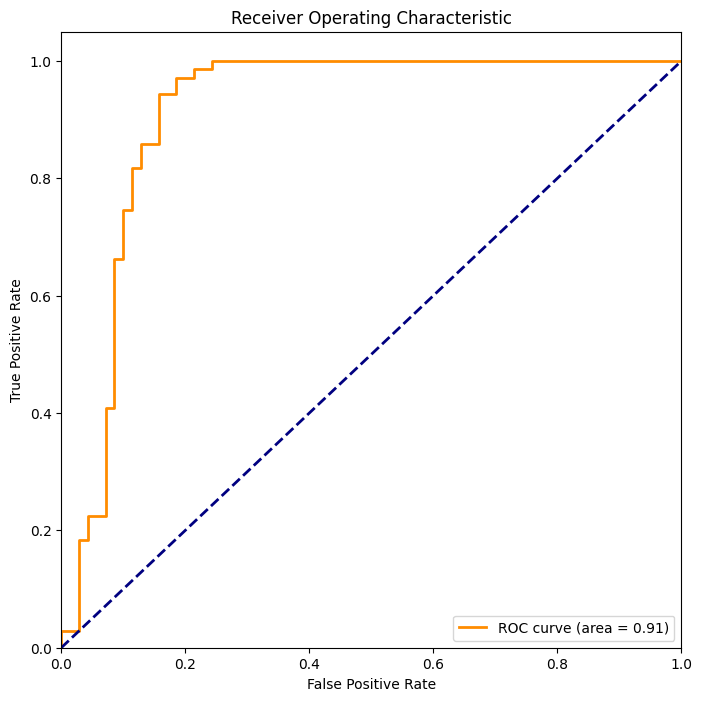

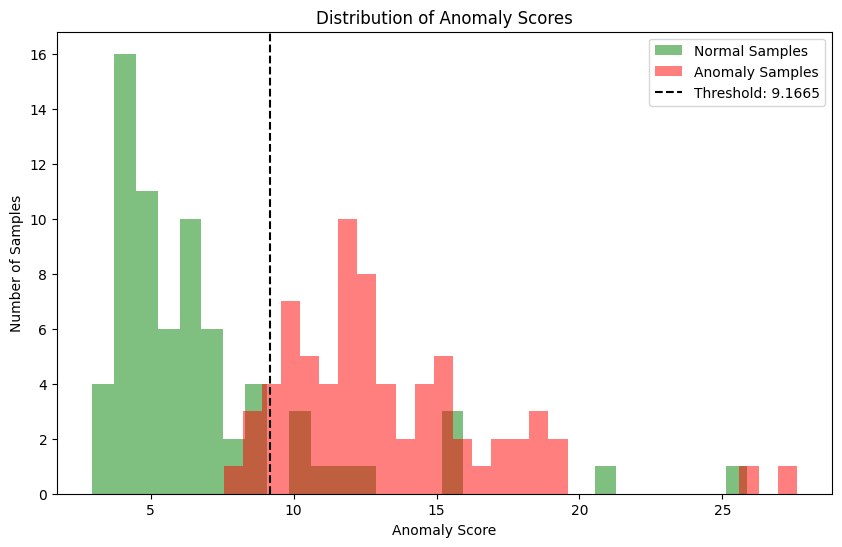

Normal samples visualization:


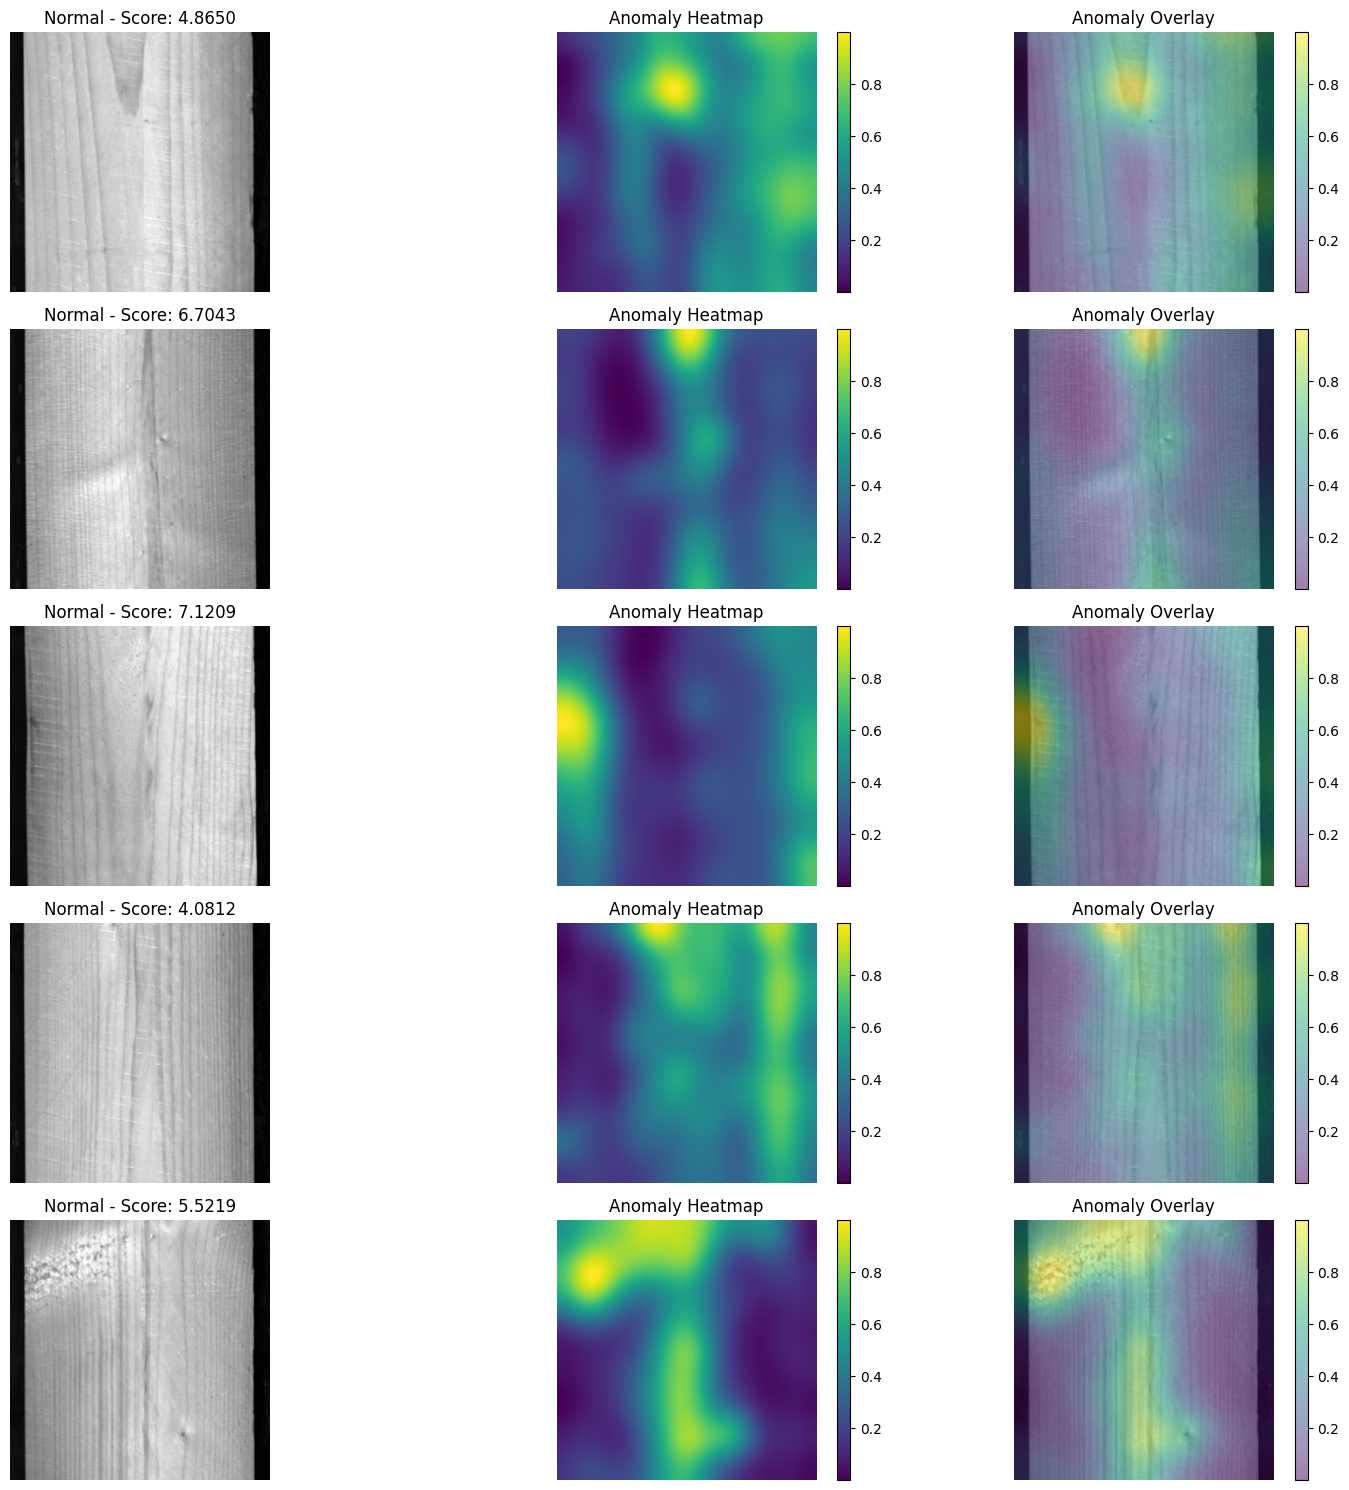

Anomaly samples visualization:


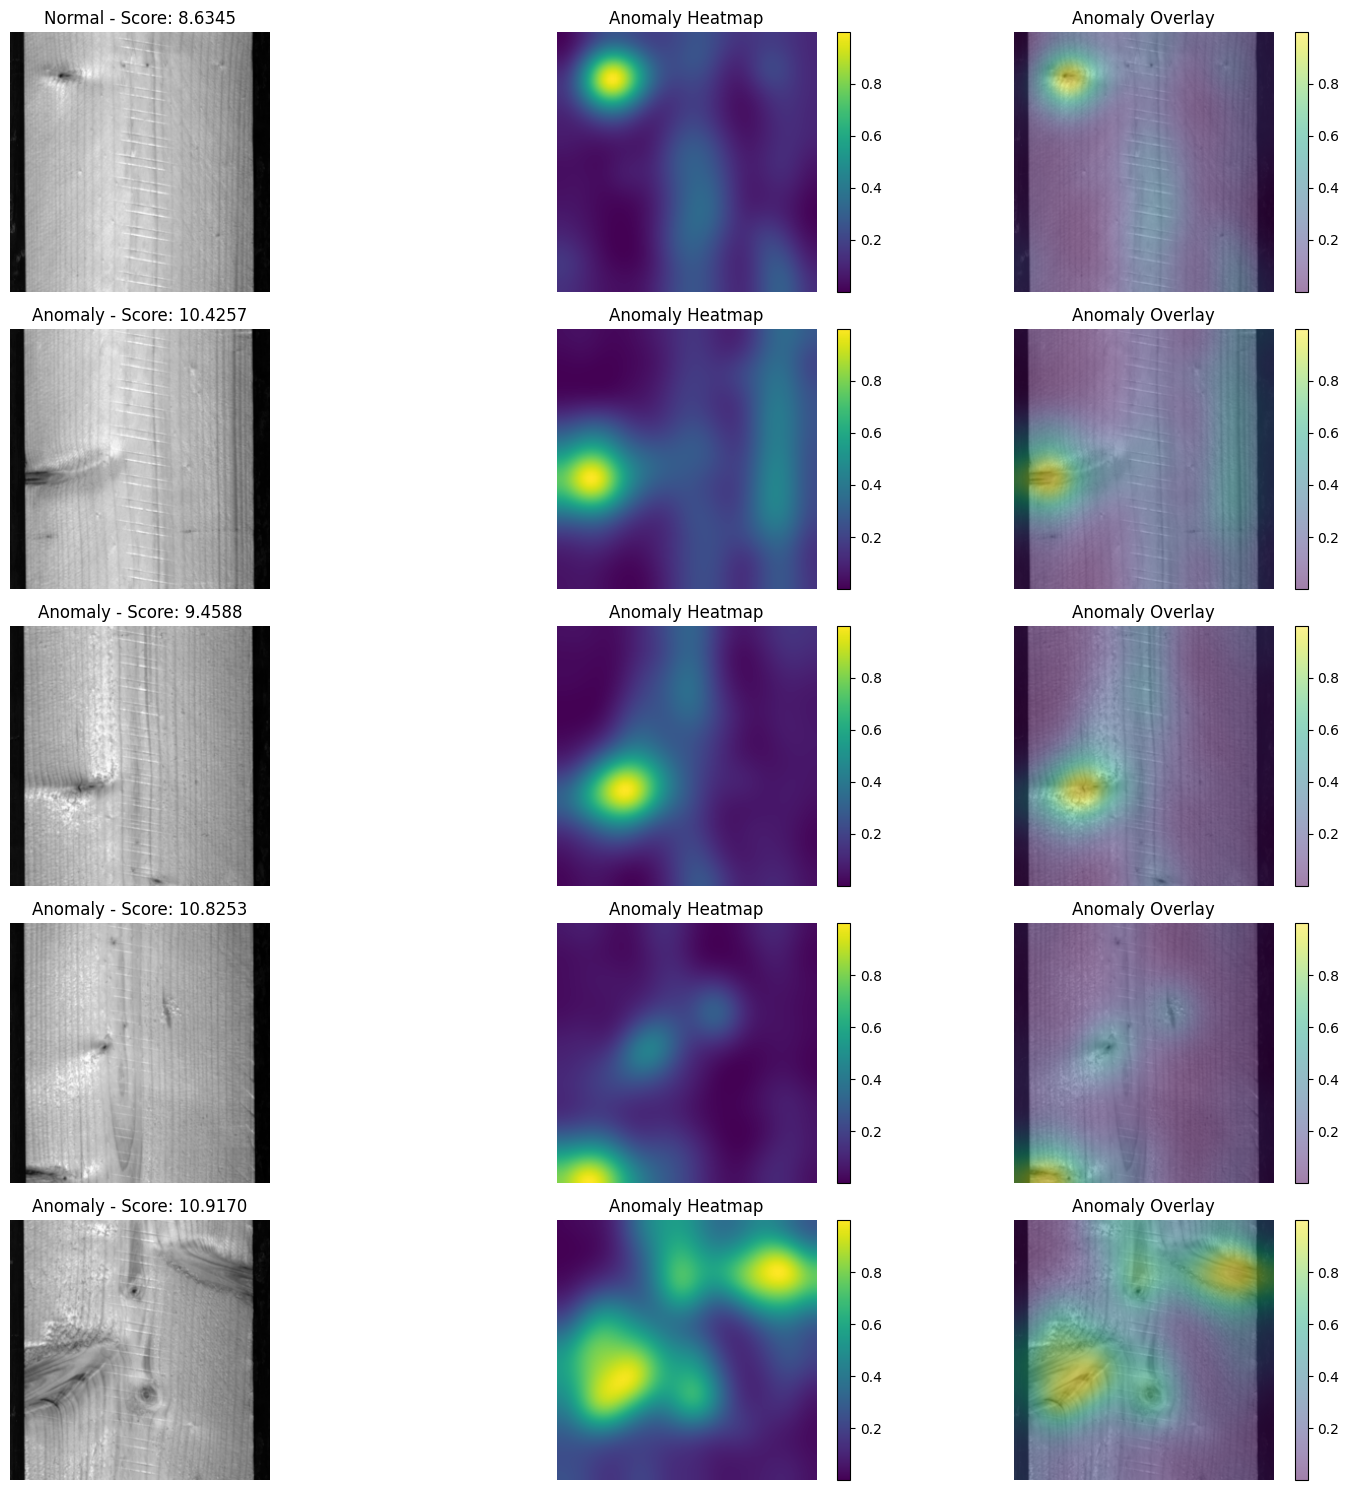

In [8]:
# Visualize ROC curve
plot_roc_curve(fpr, tpr, roc_auc)

# Visualize score distributions
plot_score_distributions(good_scores, defect_scores, threshold=optimal_threshold)

# Visualize normal samples
print("Normal samples visualization:")
normal_indices = np.random.choice(len(test_good_results["scores"]),
                                 size=min(5, len(test_good_results["scores"])),
                                 replace=False)
visualize_anomaly_detection(
    test_good_results["images"],
    test_good_results["score_maps"],
    test_good_results["scores"],
    threshold=optimal_threshold,
    indices=normal_indices
)

# Visualize anomaly samples
print("Anomaly samples visualization:")
anomaly_indices = np.random.choice(len(test_defect_results["scores"]),
                                  size=min(5, len(test_defect_results["scores"])),
                                  replace=False)
visualize_anomaly_detection(
    test_defect_results["images"],
    test_defect_results["score_maps"],
    test_defect_results["scores"],
    threshold=optimal_threshold,
    indices=anomaly_indices
)

Mean IoU: 0.0000


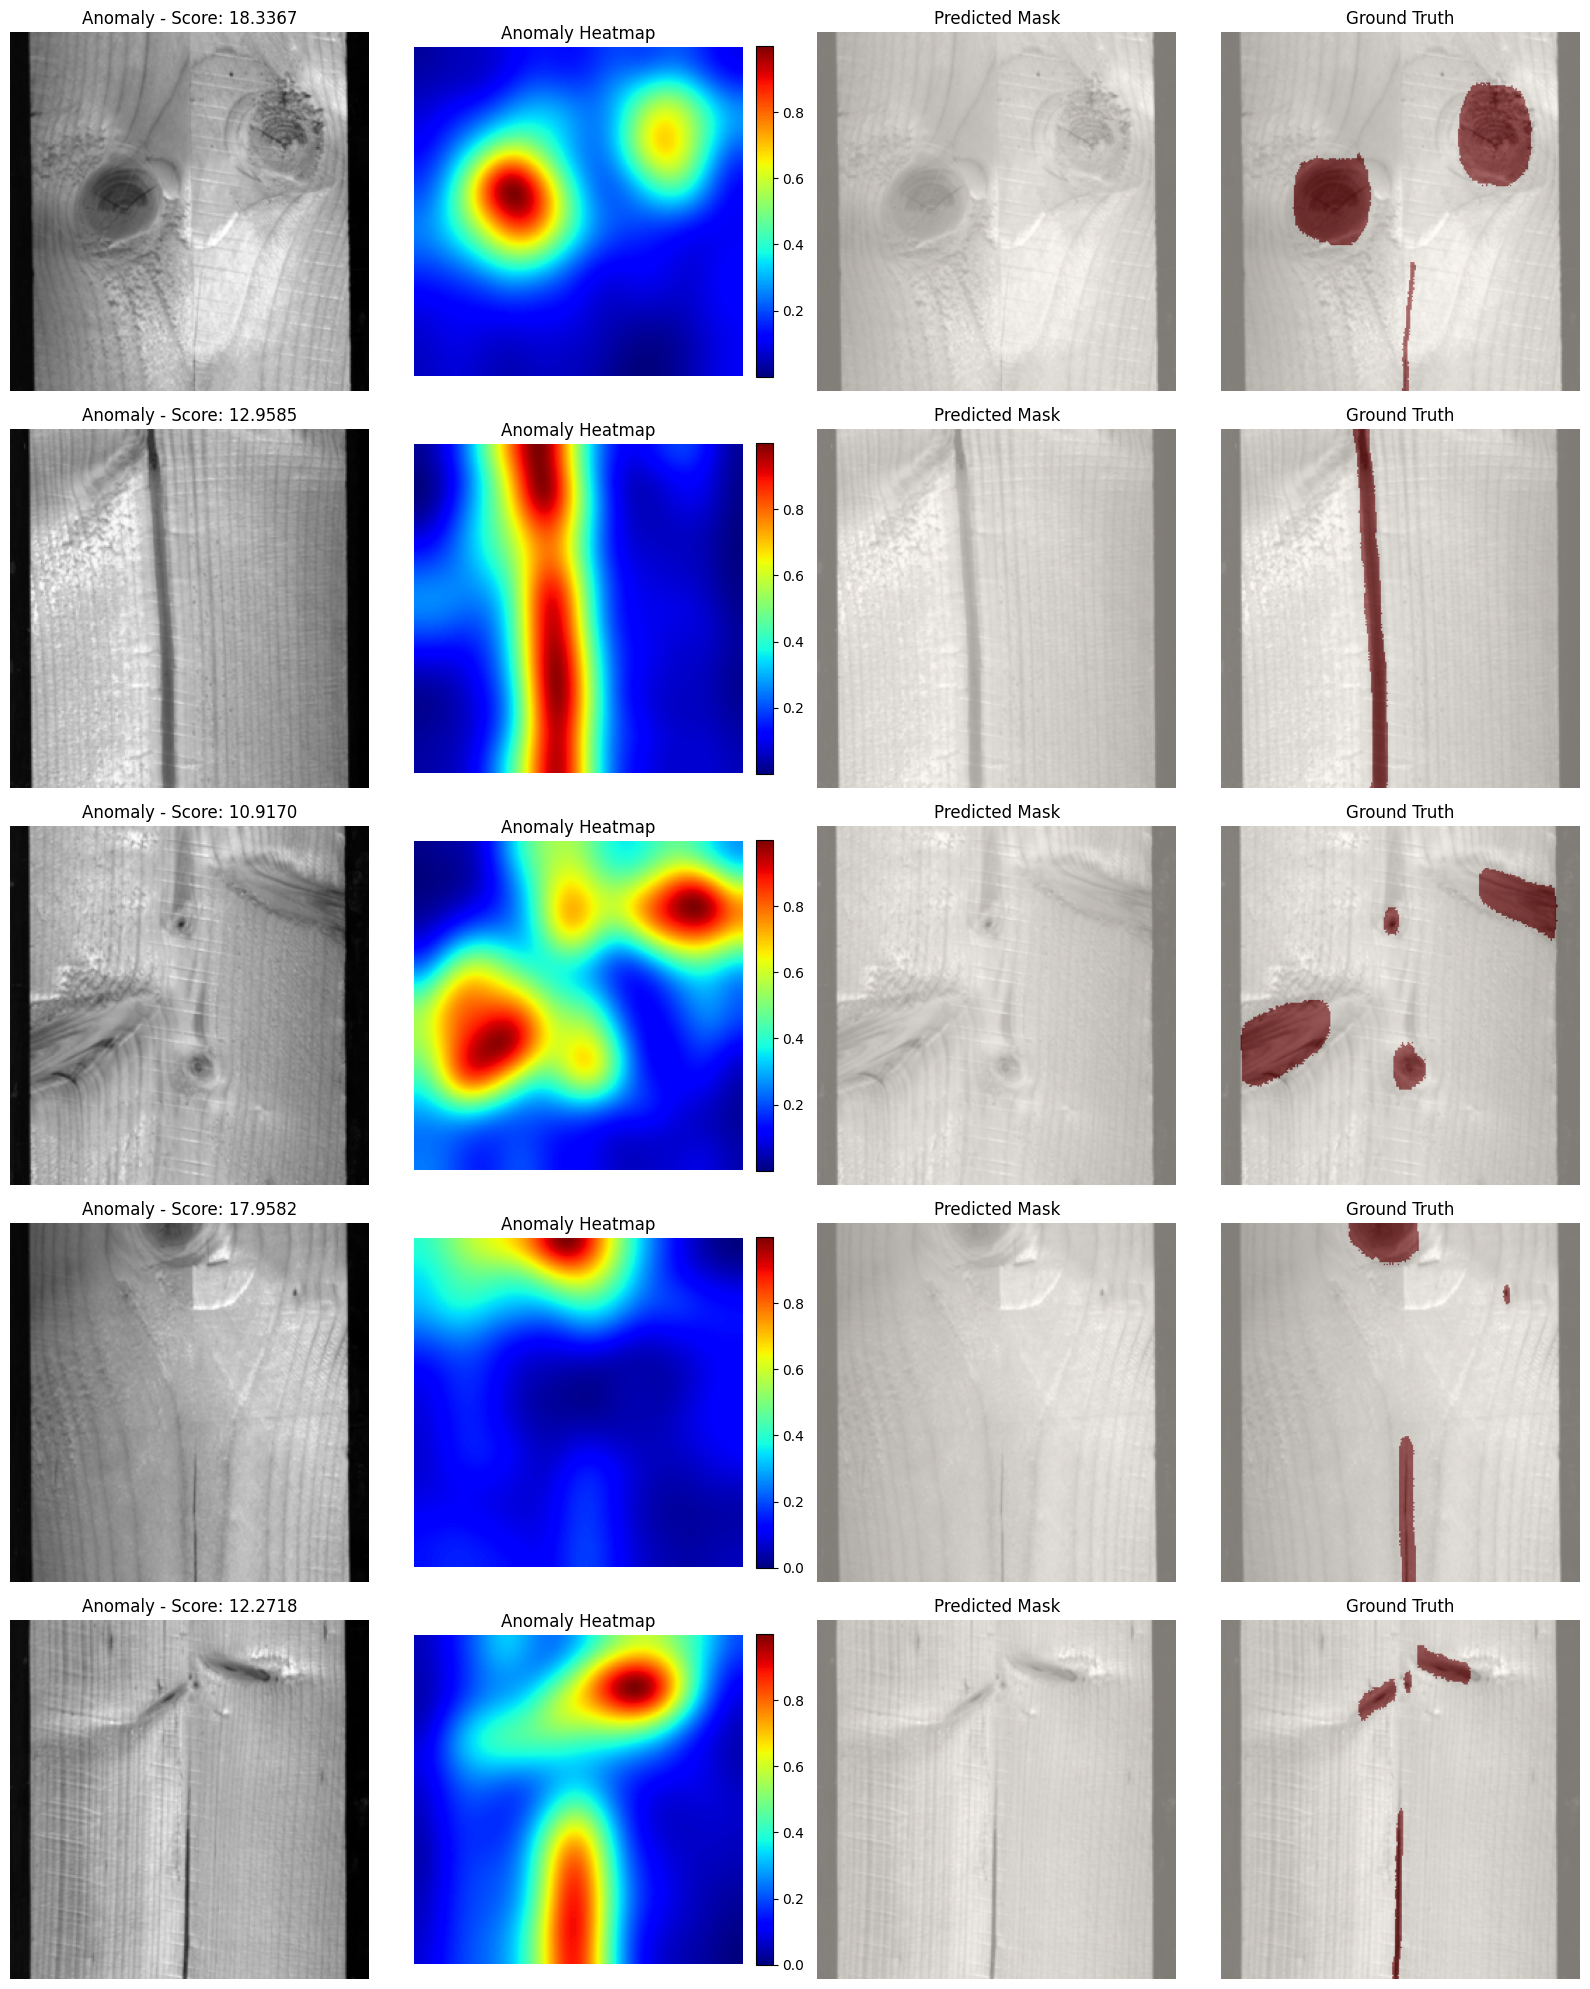

In [9]:
# Calculate IoU for the anomaly segmentation

# Pixel-level threshold for anomaly maps (may need tuning)
pixel_threshold = np.percentile(
    np.concatenate([score_map.flatten() for score_map in test_defect_results["score_maps"]]),
    80
)

# Load ground truth masks
def load_masks(mask_paths, size=(256, 256)):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        mask = (mask > 0).astype(np.float32)  # Binarize
        masks.append(mask)
    return masks

ground_truth_masks = load_masks(mask_defect_paths)

# Calculate IoU for defect samples
ious = []
for i, score_map in enumerate(test_defect_results["score_maps"]):
    if i < len(ground_truth_masks):
        # Resize score map to match ground truth dimensions
        score_map_resized = cv2.resize(score_map, (256, 256))

        # Normalize score map
        score_map_norm = (score_map_resized - score_map_resized.min()) / (score_map_resized.max() - score_map_resized.min() + 1e-7)

        # Create binary prediction mask
        pred_mask = (score_map_norm > pixel_threshold).astype(np.uint8)

        # Get ground truth mask
        gt_mask = ground_truth_masks[i].astype(np.uint8)

        # Calculate IoU
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        union = np.logical_or(pred_mask, gt_mask).sum()
        iou = intersection / (union + 1e-10)  # Add small epsilon to avoid division by zero
        ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Visualize segmentation results
visualize_segmentation_results(
    test_defect_results["images"],
    test_defect_results["score_maps"],
    test_defect_results["scores"],
    mask_defect_paths,
    threshold=pixel_threshold,
    num_samples=5
)


Evaluating PADIM with reduced dimension 50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Reduced feature dimension: 50
Feature shape: torch.Size([448, 64, 64])
Fitting multivariate Gaussian to 4096 spatial locations...


Computing covariance matrices: 100%|██████████| 64/64 [00:01<00:00, 60.83it/s]


PADIM model fitting completed


Computing Mahalanobis distances: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s]


  F1 Score: 0.8993
  ROC AUC: 0.9105

Evaluating PADIM with reduced dimension 100...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Reduced feature dimension: 100
Feature shape: torch.Size([448, 64, 64])
Fitting multivariate Gaussian to 4096 spatial locations...


Computing covariance matrices: 100%|██████████| 64/64 [00:01<00:00, 36.52it/s]


PADIM model fitting completed


Computing Mahalanobis distances: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s]


  F1 Score: 0.8961
  ROC AUC: 0.9082

Evaluating PADIM with reduced dimension 200...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Reduced feature dimension: 200
Feature shape: torch.Size([448, 64, 64])
Fitting multivariate Gaussian to 4096 spatial locations...


Computing covariance matrices: 100%|██████████| 64/64 [00:04<00:00, 15.12it/s]


PADIM model fitting completed


Computing Mahalanobis distances: 100%|██████████| 64/64 [00:13<00:00,  4.77it/s]


  F1 Score: 0.8828
  ROC AUC: 0.9115


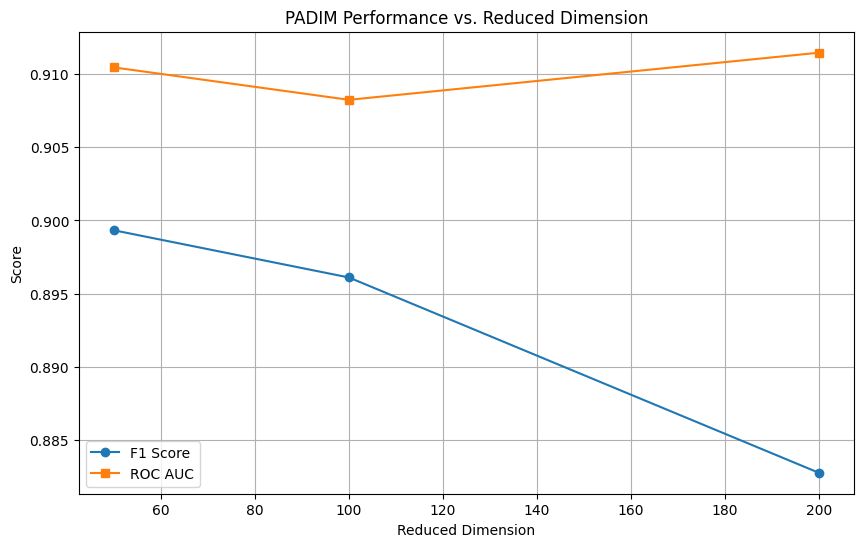

In [10]:
def tune_padim_dimension(train_loader, test_good_loader, test_defect_loader,
                         dimensions=[50, 100, 200, 300]):
    """
    Evaluate PADIM with different reduced dimensions.

    Args:
        train_loader: DataLoader with normal training samples
        test_good_loader: DataLoader with normal test samples
        test_defect_loader: DataLoader with anomaly test samples
        dimensions: List of reduced dimensions to try

    Returns:
        Dictionary with performance metrics for each dimension
    """
    results = []

    for dim in dimensions:
        print(f"\nEvaluating PADIM with reduced dimension {dim}...")

        # Initialize and train
        model = PADIM(backbone='resnet18', d_reduced=dim)
        model.fit(train_loader)

        # Predict
        good_results = model.predict(test_good_loader)
        defect_results = model.predict(test_defect_loader)

        # Metrics
        scores = np.concatenate([good_results["scores"], defect_results["scores"]])
        y_true = np.array([0] * len(good_results["scores"]) + [1] * len(defect_results["scores"]))

        fpr, tpr, thresholds = roc_curve(y_true, scores)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (scores > optimal_threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        print(f"  F1 Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")

        results.append({
            "dimension": dim,
            "f1": f1,
            "roc_auc": roc_auc,
            "threshold": optimal_threshold
        })

    return results

tune_results = tune_padim_dimension(
    train_loader,
    test_good_loader,
    test_defect_loader,
    dimensions=[50, 100, 200]
)


plt.figure(figsize=(10, 6))
plt.plot([r["dimension"] for r in tune_results], [r["f1"] for r in tune_results], marker='o', label="F1 Score")
plt.plot([r["dimension"] for r in tune_results], [r["roc_auc"] for r in tune_results], marker='s', label="ROC AUC")
plt.xlabel("Reduced Dimension")
plt.ylabel("Score")
plt.title("PADIM Performance vs. Reduced Dimension")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import pickle

def save_padim_model(model, filepath):
    """
    Save the trained PADIM model

    Args:
        model: Trained PADIM model
        filepath: Path to save the model
    """
    # Create a dictionary with the important parts of the model
    model_dict = {
        "means": model.means.cpu().numpy() if isinstance(model.means, torch.Tensor) else model.means,
        "cov_invs": model.cov_invs.cpu().numpy() if isinstance(model.cov_invs, torch.Tensor) else model.cov_invs,
        "embedding_ids": model.embedding_ids.cpu().numpy() if isinstance(model.embedding_ids, torch.Tensor) else model.embedding_ids,
        "feature_shape": model.feature_shape,
        "d_reduced": model.d_reduced,
        "backbone": model.backbone
    }

    # Save to disk
    with open(filepath, 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Model saved to {filepath}")

# Save the trained model
save_path = "/content/drive/MyDrive/wood_dataset/padim_model.pkl"
save_padim_model(padim, save_path)

Model saved to /content/drive/MyDrive/wood_dataset/padim_model.pkl


In [13]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Create HTML report for PADIM model
def create_padim_report(padim_model, good_results, defect_results, optimal_threshold, f1, roc_auc, fpr, tpr, mask_paths=None):
    # Combine results
    all_scores = np.concatenate([good_results["scores"], defect_results["scores"]])
    all_maps = np.concatenate([good_results["score_maps"], defect_results["score_maps"]])
    all_imgs = good_results["images"] + defect_results["images"]
    all_filenames = good_results["filenames"] + defect_results["filenames"]

    # Ground truth labels (0 for normal, 1 for anomaly)
    true_labels = np.array([0] * len(good_results["scores"]) + [1] * len(defect_results["scores"]))

    # Get predictions based on optimal threshold
    predictions = (all_scores > optimal_threshold).astype(int)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Image_Path': all_filenames,
        'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
        'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
        'Anomaly_Score': all_scores,
        'Is_Correct': true_labels == predictions
    })

    # Calculate performance metrics
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions,
                                         target_names=['Good', 'Defect'],
                                         output_dict=True)

    # Generate confusion matrix figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Defect'],
                yticklabels=['Good', 'Defect'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Save confusion matrix to bytes for embedding in HTML
    conf_matrix_img = BytesIO()
    plt.tight_layout()
    plt.savefig(conf_matrix_img, format='png')
    plt.close()
    conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

    # Generate ROC curve figure
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Save ROC curve to bytes for embedding in HTML
    roc_img = BytesIO()
    plt.tight_layout()
    plt.savefig(roc_img, format='png')
    plt.close()
    roc_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

    # Generate score distribution figure
    plt.figure(figsize=(10, 6))
    sns.histplot(data=results_df, x='Anomaly_Score', hue='True_Label',
                 bins=30, kde=True, element='step')
    plt.axvline(x=optimal_threshold, color='red', linestyle='--',
                label=f'Threshold = {optimal_threshold:.4f}')
    plt.legend()
    plt.title('Anomaly Score Distribution')

    # Save distribution figure to bytes for embedding in HTML
    dist_img = BytesIO()
    plt.tight_layout()
    plt.savefig(dist_img, format='png')
    plt.close()
    dist_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

    # Example visualizations with heatmap overlays
    example_images = []
    # Use fewer examples if needed
    num_good_examples = min(3, len(good_results["images"]))
    num_defect_examples = min(3, len(defect_results["images"]))

    # Generate good example visualizations
    for i in range(num_good_examples):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Get original image and score map
        original_img = good_results["images"][i].permute(1, 2, 0).cpu().numpy()
        # For grayscale (3 identical channels), take first channel
        if np.allclose(original_img[:,:,0], original_img[:,:,1]) and np.allclose(original_img[:,:,1], original_img[:,:,2]):
            original_img = original_img[:,:,0]

        # Denormalize image for better visualization
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

        # Get score map and normalize
        score_map = good_results["score_maps"][i]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)
        score_map_resized = cv2.resize(score_map_norm, (original_img.shape[1], original_img.shape[0]))

        # First subplot - Original Good Image
        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title(f'Original Good Image #{i}')
        axes[0].axis('off')

        # Second subplot - Anomaly Heatmap
        heatmap = axes[1].imshow(score_map_resized, cmap='jet')
        axes[1].set_title('Anomaly Heatmap')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        # Third subplot - Overlay
        axes[2].imshow(original_img, cmap='gray')
        overlay = axes[2].imshow(score_map_resized, cmap='jet', alpha=0.5)
        axes[2].set_title(f'Anomaly Score: {good_results["scores"][i]:.4f}')
        axes[2].axis('off')
        fig.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        idx = i
        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Good',
            'pred_class': 'Good' if good_results["scores"][i] <= optimal_threshold else 'Defect',
            'is_correct': good_results["scores"][i] <= optimal_threshold,
            'score': good_results["scores"][i],
            'filename': os.path.basename(good_results["filenames"][i])
        })

    # Generate defect example visualizations
    for i in range(num_defect_examples):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Get original image and score map
        original_img = defect_results["images"][i].permute(1, 2, 0).cpu().numpy()
        # For grayscale (3 identical channels), take first channel
        if np.allclose(original_img[:,:,0], original_img[:,:,1]) and np.allclose(original_img[:,:,1], original_img[:,:,2]):
            original_img = original_img[:,:,0]

        # Denormalize image for better visualization
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

        # Get score map and normalize
        score_map = defect_results["score_maps"][i]
        score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)
        score_map_resized = cv2.resize(score_map_norm, (original_img.shape[1], original_img.shape[0]))

        # First subplot - Original Defect Image
        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title(f'Original Defect Image #{i}')
        axes[0].axis('off')

        # Second subplot - Anomaly Heatmap
        heatmap = axes[1].imshow(score_map_resized, cmap='jet')
        axes[1].set_title('Anomaly Heatmap')
        axes[1].axis('off')
        fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

        # Third subplot - Overlay
        axes[2].imshow(original_img, cmap='gray')
        overlay = axes[2].imshow(score_map_resized, cmap='jet', alpha=0.5)
        axes[2].set_title(f'Anomaly Score: {defect_results["scores"][i]:.4f}')
        axes[2].axis('off')
        fig.colorbar(overlay, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        idx = i + len(good_results["images"])
        example_images.append({
            'image': img_b64,
            'index': idx,
            'true_class': 'Defect',
            'pred_class': 'Good' if defect_results["scores"][i] <= optimal_threshold else 'Defect',
            'is_correct': defect_results["scores"][i] > optimal_threshold,
            'score': defect_results["scores"][i],
            'filename': os.path.basename(defect_results["filenames"][i])
        })

    # Add segmentation examples if mask paths are provided
    segmentation_examples = []
    if mask_paths:
        # Load masks
        ground_truth_masks = load_masks(mask_paths)

        # Pixel-level threshold for anomaly maps
        pixel_threshold = np.percentile(
            np.concatenate([score_map.flatten() for score_map in defect_results["score_maps"]]), 80
        )

        # Generate 3 segmentation examples
        for i in range(min(3, len(ground_truth_masks))):
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))

            # Get original image
            original_img = defect_results["images"][i].permute(1, 2, 0).cpu().numpy()
            if np.allclose(original_img[:,:,0], original_img[:,:,1]) and np.allclose(original_img[:,:,1], original_img[:,:,2]):
                original_img = original_img[:,:,0]
            original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

            # Get score map
            score_map = defect_results["score_maps"][i]
            score_map_norm = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-7)
            score_map_resized = cv2.resize(score_map_norm, (256, 256))

            # Binary prediction mask
            pred_mask = (score_map_resized > pixel_threshold).astype(np.float32)

            # Get ground truth mask
            gt_mask = ground_truth_masks[i]

            # Calculate IoU
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            iou = intersection / (union + 1e-10)

            # Plot original image
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title(f'Defect Image #{i}')
            axes[0].axis('off')

            # Plot predicted mask
            axes[1].imshow(original_img, cmap='gray')
            axes[1].imshow(pred_mask, cmap='OrRd', alpha=0.5)
            axes[1].set_title(f'Predicted Mask')
            axes[1].axis('off')

            # Plot ground truth
            axes[2].imshow(original_img, cmap='gray')
            axes[2].imshow(gt_mask, cmap='OrRd', alpha=0.5)
            axes[2].set_title(f'Ground Truth (IoU: {iou:.4f})')
            axes[2].axis('off')

            plt.tight_layout()

            img_bytes = BytesIO()
            plt.savefig(img_bytes, format='png')
            plt.close(fig)
            img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

            segmentation_examples.append({
                'image': img_b64,
                'index': i,
                'iou': iou,
                'filename': os.path.basename(defect_results["filenames"][i])
            })

    # Create HTML report
    html_content = f'''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Wood Defect Detection - PADIM Results</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .header {{ text-align: center; margin-bottom: 30px; }}
            .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; }}
            .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; }}
            .chart-container {{ margin-bottom: 30px; }}
            .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
            .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            .results-table th {{ background-color: #f2f2f2; }}
            .example-container {{ margin-bottom: 40px; }}
            .example-item {{ margin-bottom: 20px; }}
            .correct {{ color: green; }}
            .incorrect {{ color: red; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Wood Defect Detection Report (PADIM Model)</h1>
                <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                <p>Using PADIM with feature dimension: {padim_model.d_reduced}</p>
            </div>

            <h2>Performance Summary</h2>
            <div class="metrics">
                <div class="metric-card">
                    <h3>Accuracy</h3>
                    <p>{(true_labels == predictions).mean():.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>F1 Score</h3>
                    <p>{f1:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>ROC AUC</h3>
                    <p>{roc_auc:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>Optimal Threshold</h3>
                    <p>{optimal_threshold:.4f}</p>
                </div>
            </div>

            <div class="chart-container">
                <h2>Confusion Matrix</h2>
                <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>ROC Curve</h2>
                <img src="data:image/png;base64,{roc_b64}" alt="ROC Curve" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>Anomaly Score Distribution</h2>
                <img src="data:image/png;base64,{dist_b64}" alt="Score Distribution" style="max-width:100%;">
            </div>

            <h2>Classification Results</h2>
            <table class="results-table">
                <tr>
                    <th>Class</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-Score</th>
                    <th>Support</th>
                </tr>
                <tr>
                    <td>Good</td>
                    <td>{class_report['Good']['precision']:.4f}</td>
                    <td>{class_report['Good']['recall']:.4f}</td>
                    <td>{class_report['Good']['f1-score']:.4f}</td>
                    <td>{class_report['Good']['support']}</td>
                </tr>
                <tr>
                    <td>Defect</td>
                    <td>{class_report['Defect']['precision']:.4f}</td>
                    <td>{class_report['Defect']['recall']:.4f}</td>
                    <td>{class_report['Defect']['f1-score']:.4f}</td>
                    <td>{class_report['Defect']['support']}</td>
                </tr>
            </table>

            <h2>Example Visualizations</h2>
            <div class="example-container">
    '''

    # Add example visualizations to HTML
    for example in example_images:
        correct_class = 'correct' if example['is_correct'] else 'incorrect'
        html_content += f'''
                <div class="example-item">
                    <h3>Image: {example['filename']} -
                        <span>True: {example['true_class']}, </span>
                        <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                        <span>(Score: {example['score']:.4f})</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
                </div>
        '''

    # Add segmentation examples if available
    # Add segmentation examples if available
    if segmentation_examples:
        html_content += '''
            <h2>Segmentation Examples</h2>
            <div class="example-container">
        '''

        for example in segmentation_examples:
            html_content += f'''
                <div class="example-item">
                    <h3>Image: {example['filename']} -
                       <span>IoU: {example['iou']:.4f}</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Segmentation Example" style="max-width:100%;">
                </div>
            '''

        html_content += '''
            </div>
        '''

    # Close the HTML document
    html_content += '''
            </div>
        </div>
    </body>
    </html>
    '''

    return html_content

# Create report and save to file
report_html = create_padim_report(
    padim_model=padim,
    good_results=test_good_results,
    defect_results=test_defect_results,
    optimal_threshold=optimal_threshold,
    f1=f1,
    roc_auc=roc_auc,
    fpr=fpr,
    tpr=tpr,
    mask_paths=mask_defect_paths
)

# Save the HTML report to the data directory
report_path = os.path.join(DATASET_DIR, 'padim_report.html')
with open(report_path, 'w') as f:
    f.write(report_html)

print(f"PADIM classification report saved to: {report_path}")

# Output a summary of classification results
all_scores = np.concatenate([test_good_results["scores"], test_defect_results["scores"]])
true_labels = np.array([0] * len(test_good_results["scores"]) + [1] * len(test_defect_results["scores"]))
predictions = (all_scores > optimal_threshold).astype(int)

print("\nPADIM Classification Summary:")
print(f"Total Images: {len(all_scores)}")
print(f"Good Images: {len(test_good_results['scores'])}, Defect Images: {len(test_defect_results['scores'])}")
print(f"Correctly Classified: {(true_labels == predictions).sum()} / {len(all_scores)}")
print(f"Accuracy: {(true_labels == predictions).mean():.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Mean IoU (for defect segmentation): {mean_iou:.4f}")

PADIM classification report saved to: /content/drive/MyDrive/wood_dataset/wood/padim_report.html

PADIM Classification Summary:
Total Images: 141
Good Images: 70, Defect Images: 71
Correctly Classified: 125 / 141
Accuracy: 0.8865
F1 Score: 0.8919
ROC AUC: 0.9121
Mean IoU (for defect segmentation): 0.0000
